In [2]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats
from matplotlib.patches import Circle


from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 3.17 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [3]:
src = f"/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (4000, 8, 70, 3, 6)
b (4000, 8, 70, 3, 6)
L (4000, 8, 70, 3, 6)
ℓ (4000, 8, 70, 3, 6)
H (4000, 8, 70, 3, 6)


In [5]:
compound_position = encoder_dict[model.features[1]].inverse_transform(sorted(df['compound_position'].unique()))

a = posterior_samples[site.a]
subjects = df['participant'].unique()
subjects = sorted(encoder_dict['participant'].inverse_transform(subjects))
positions = sorted(df['compound_position'].unique())
subjects = sorted(df['participant'].unique())
sizes = sorted(df['compound_size'].unique())
muscles = model.response

In [119]:
encoder_dict[model.features[1]].inverse_transform(positions)

array(['-C5LL', '-C5L', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6LL',
       '-C6L', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR', 'C5L-C5LL',
       'C5LM1-C5L', 'C5LM1-C5LL', 'C5LM2-C5L', 'C5LM2-C5LL',
       'C5LM2-C5LM1', 'C5LM2-C5M', 'C5LM2-C6L', 'C5LM2-C6LL', 'C5M-C5L',
       'C5M-C5LL', 'C5M-C5LM', 'C5M-C5LM1', 'C5M-C5LM2', 'C5M-C6L',
       'C5M-C6LL', 'C6L-C6LL', 'C6LL-C6L', 'C6LM-C6L', 'C6LM-C6LL',
       'C6LM-C6M', 'C6LM-C6R', 'C6LM-C6RM', 'C6LM-C6RR', 'C6LM1-C6L',
       'C6LM1-C6LL', 'C6LM2-C6L', 'C6LM2-C6LL', 'C6LM2-C6LM1', 'C6M-C6L',
       'C6M-C6LL', 'C6M-C6LM', 'C6M-C6LM1', 'C6M-C6LM2', 'C6M-C6R',
       'C6M-C6RM', 'C6M-C6RR', 'C6R-C6RR', 'C6RM-C6R', 'C6RM-C6RR',
       'C7LM-C7M', 'C7LM-C7R', 'C7LM-C7RM', 'C7LM-C7RR', 'C7M-C7R',
       'C7M-C7RM', 'C7M-C7RR', 'C7R-C7RR', 'C7RM-C7R', 'C7RM-C7RR'],
      dtype=object)

In [117]:
positions[0], positions[1] = positions[1], positions[0]
positions[6], positions[7] = positions[7], positions[6]

In [120]:
p1 = positions[:6]
p2 = positions[6:12]
keys = [p1, p2]

In [121]:
a.shape

(4000, 8, 70, 3, 6)

In [9]:
test = a[:,0,(1,2), 0,...]

In [10]:
test[:,0,...].shape

(4000, 6)

In [11]:
muscles = model.response

In [122]:
encoder_dict[model.features[2]].inverse_transform([0,1,2])

array(['B', 'S', 'S-B'], dtype=object)

In [13]:
keys

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]

In [14]:
sizes = sizes[:2]

In [15]:
sizes

[0, 1]

In [16]:
norm_y = []
norm_x = []
size_ind = 0
target_compound = 5

for subject_ind, subject in enumerate(subjects):
    for k in keys:
        for s in sizes:
            for m_ind, m in enumerate(muscles):
            # Fix the subject index and size index
                a_temp = a[:, subject_ind, k, :2, m_ind]
                mean_thres = np.nanmean(a_temp[:,target_compound,...],axis=(0,-1))
                curr_params = [
                    params[:, subject_ind, k, s, m_ind, None] for params in params
                ]
                
                x_temp = np.array([1.2*mean_thres])[None, None, None,None,None,:]

                temp_thresh = F.rectified_logistic(
                    x_temp, #x_temp
                    *curr_params
                )
                
                # Remove offset
                temp_thresh = temp_thresh - curr_params[2]
                norm_y.append(temp_thresh)
                norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(keys), len(sizes), len(muscles), *norm_x.shape[4:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects), len(keys), len(sizes), len(muscles), *norm_y.shape[4:])
norm_y = ma.masked_invalid(norm_y)


In [17]:
norm_y.shape

(8, 2, 2, 6, 4000, 6, 1)

In [18]:
big = norm_y[:,:,0,...]
small = norm_y[:,:,1,...]

In [19]:
big.shape

(8, 2, 6, 4000, 6, 1)

In [20]:
big_ind = [0,1,2,2,5]
small_ind = [0,1,3,4,5]

# Max Slope


In [21]:
sat_point = params[2]+params[4]

# Threshold

In [123]:
big_keys = [[0, 1, 2, 2, 5], [6, 7, 8,8,  11]]
small_keys = [[0, 1, 3,4, 5], [6,7,9,10,11]]

In [124]:
norm_a = a[:,:,:12,:2,:]
norm_a = ma.masked_invalid(norm_a)


In [125]:
norm_a.shape

(4000, 8, 12, 2, 6)

In [126]:
norm_a = norm_a / ma.median(norm_a, axis=(2,3,4), keepdims=True)

In [127]:
arr_big = []
size_ind = 0

for subject_ind, subject in enumerate(subjects):
    for k in big_keys:
        a_temp = norm_a[:, subject_ind, k, size_ind,:]
        arr_big.append(a_temp)
arr_big = np.array(arr_big)
arr_big = arr_big.reshape(len(subjects), len(big_keys), *arr_big.shape[1:])

In [128]:
arr_small = []
size_ind = 1

for subject_ind, subject in enumerate(subjects):
    for k in small_keys:
        a_temp = norm_a[:, subject_ind, k, size_ind,:]
        arr_small.append(a_temp)
arr_small = np.array(arr_small)
arr_small = arr_small.reshape(len(subjects), len(small_keys), *arr_small.shape[1:]) 

In [129]:
arr_big = ma.masked_invalid(arr_big)

In [130]:
arr_big.shape

(8, 2, 4000, 5, 6)

# Bubble Plot

In [30]:
labels = ['L', 'LL', 'LM', 'M']

In [31]:
src = f"/home/andres/repos/rat-mapping-paper/notebooks/C_SMA_LAR/big_probabilities.pkl"

with open(src, "rb") as f:
    p_big_c5, p_big_c6 = pickle.load(f)

In [32]:
p_big_c5.shape

(8, 4000, 5, 6, 500)

In [33]:
p_big_c5 = p_big_c5[:,:,[0,1,2,4],:,:]
p_big_c6 = p_big_c6[:,:,[0,1,2,4],:,:]

In [34]:
p_big_c5_means = p_big_c5.mean(axis=(1,4))
p_big_c6_means = p_big_c6.mean(axis=(1,4))

In [35]:
a_big_c5 = arr_big[:,0,...]
a_big_c6 = arr_big[:,1,...]

In [36]:
means_c5 = a_big_c5.mean(axis=(0,1))
means_c6 = a_big_c6.mean(axis=(0,1))

In [37]:
rat_big_c5 = ma.mean(a_big_c5, axis=1)
rat_big_c6 = ma.mean(a_big_c6, axis=1)

In [38]:
mean_p_c5 = p_big_c5_means.mean(axis=0)
mean_p_c6 = p_big_c6_means.mean(axis=0)

In [39]:
max_p_c5 = np.max(mean_p_c5, axis=1)
max_p_c5 = max_p_c5[:,np.newaxis]

max_p_c6 = np.max(mean_p_c6, axis=1)
max_p_c6 = max_p_c6[:,np.newaxis]

norm_p_c5 = mean_p_c5/max_p_c5
norm_p_c6 = mean_p_c6/max_p_c6

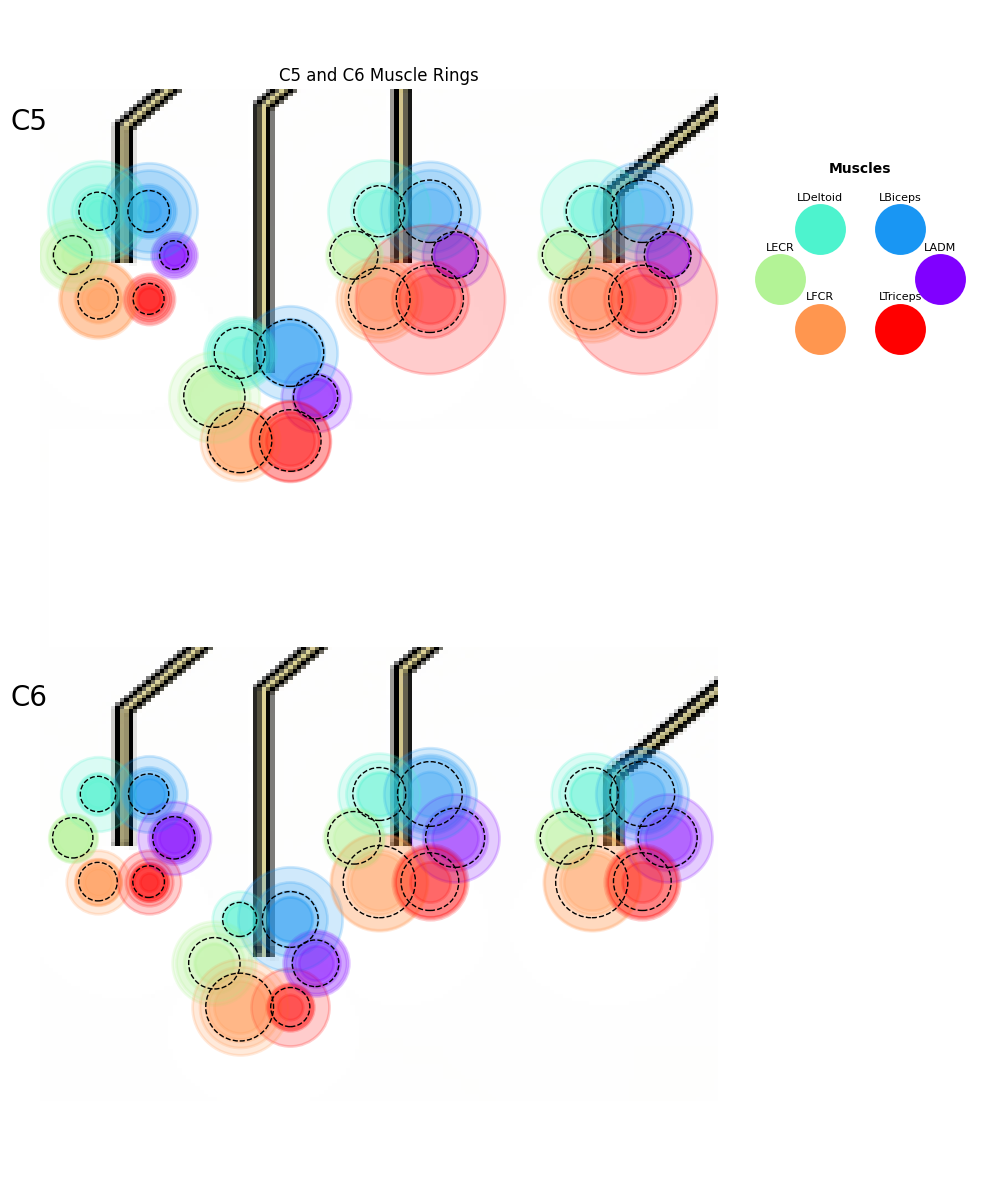

In [40]:
rat_big_c5 = rat_big_c5.copy() if not rat_big_c5.flags.writeable else rat_big_c5
rat_big_c6 = rat_big_c6.copy() if not rat_big_c6.flags.writeable else rat_big_c6
colors = model._get_colors(model.n_response)
colors = colors.copy() if not colors.flags.writeable else colors

x_vals_big_c5 = {"L":(126, 348),"LL":(56, 418), "LM":(195, 418), "M":(300, 418)}
x_vals_big_c6 = {"L":(126, 68),"LL":(56, 130), "LM":(195, 130), "M":(300, 130)}

# Plotting
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1.5])



ax_image = fig.add_subplot(gs[0])
ax_image.set_title("C5 and C6 Muscle Rings")
ax_image.set_axis_off()  # Hide axis
ax_legend = fig.add_subplot(gs[1])
# Function to plot the muscle rings
def plot_ring(center, group, means, mask):
    radius = 25
    angle_offsets = np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)
    alpha = 0.2            
    for s, ind in enumerate(subjects):
        for musc_idx, angle in enumerate(angle_offsets):
            offset_x = radius * np.cos(angle)
            offset_y = radius * np.sin(angle)
            if means[s,:].mask.all():
                continue
            eff_size = (1 / means[s][musc_idx]) * 1100
            
            ax_image.scatter(
                center[0] + offset_x,
                center[1] + offset_y,
                s=eff_size,
                alpha=alpha,
                color=colors[musc_idx],
                linewidth=2,
            )

# Plot for C5 and C6 muscle locations
for i, (key, center) in enumerate(x_vals_big_c5.items()):
    plot_ring(center, "C5", rat_big_c5[:,i,:], rat_big_c5.mask)
for i, (key, center) in enumerate(x_vals_big_c6.items()):
    plot_ring(center, "C6", rat_big_c6[:,i,:], rat_big_c6.mask)

angle_offsets = np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)
radius = 25
c5_means = rat_big_c5.mean(axis=0)
c6_means = rat_big_c6.mean(axis=0)

for i, (key, center) in enumerate(x_vals_big_c5.items()):
    for musc_idx, angle in enumerate(angle_offsets):
        # if means[s][musc_idx].mask:
        #     continue
        offset_x = radius * np.cos(angle)
        offset_y = radius * np.sin(angle)
        temp_mean = c5_means[:,musc_idx] 
        if rat_big_c5[s,:].mask.all():
            continue
        eff_size = (1 / temp_mean[i]) * 1100
        alpha = 0           
        muscle_name = muscles[musc_idx]

        ax_image.scatter(
            center[0] + offset_x,
            center[1] + offset_y,
            s=eff_size,
            facecolor = 'none',
            linewidth=1,
            edgecolor = 'black',
            linestyle='dashed',
            
        )
for i, (key, center) in enumerate(x_vals_big_c6.items()):
    for musc_idx, angle in enumerate(angle_offsets):
        # if means[s][musc_idx].mask:
        #     continue
        offset_x = radius * np.cos(angle)
        offset_y = radius * np.sin(angle)
        temp_mean = c6_means[:,musc_idx] 
        if rat_big_c6[s,:].mask.all():
            continue
        eff_size = (1 / temp_mean[i]) * 1100
        alpha = 0.2            
        muscle_name = muscles[musc_idx]

        ax_image.scatter(
            center[0] + offset_x,
            center[1] + offset_y,
            s=eff_size,
            facecolor = 'none',
            linewidth=1,
            edgecolor = 'black',
            linestyle='dashed'
        )

# Customize plot
im = plt.imread("/home/andres/C_SMA_LAR_white3.png")

ax_image.text(0, 480, "C5", fontsize= 20)
ax_image.text(0, 195, "C6", fontsize= 20)


ax_image.set_title("C5 and C6 Muscle Rings")
ax_image.set_axis_off()
ax_image.imshow(im, extent=[15, 350, 0, 500])

# Create legend with a ring of circles for each muscle
legend_center = (0.5, 0.77)  # Legend position in normalized axis coordinates
legend_radius = 0.07         # Radius for legend ring
angle_offsets = np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)

# Draw circles and text for legend
for musc_idx, angle in enumerate(np.linspace(0, 2 * np.pi, len(muscles), endpoint=False)):
    offset_x = legend_radius * np.cos(angle)
    offset_y = legend_radius * np.sin(angle)
    ax_legend.scatter(
        legend_center[0] + offset_x*4.5,
        legend_center[1] + offset_y*0.7,
        s=1200,  # Fixed size for legend circles
        color=colors[musc_idx],
        alpha=1.0,
        transform=ax_legend.transAxes,
        zorder=10,
        linewidth=2
    )
    ax_legend.text(
        legend_center[0] + offset_x*4.5,
        legend_center[1] + offset_y*0.7+0.027,
        muscles[musc_idx],
        fontsize=8,
        ha="center",
        va="center",
        transform=ax_legend.transAxes
    )

# Add title for the legend
ax_legend.text(
    legend_center[0],
    legend_center[1] + legend_radius+0.024,
    "Muscles",
    transform=ax_legend.transAxes,
    fontsize=10,
    ha="center",
    va="center",
    fontweight="bold"
)
ax_legend.set_axis_off()
plt.tight_layout()
plt.show()



In [41]:
colors.shape

(6, 4)

# Plot indiviudal rats

NameError: name 'a_mean_big_c6' is not defined

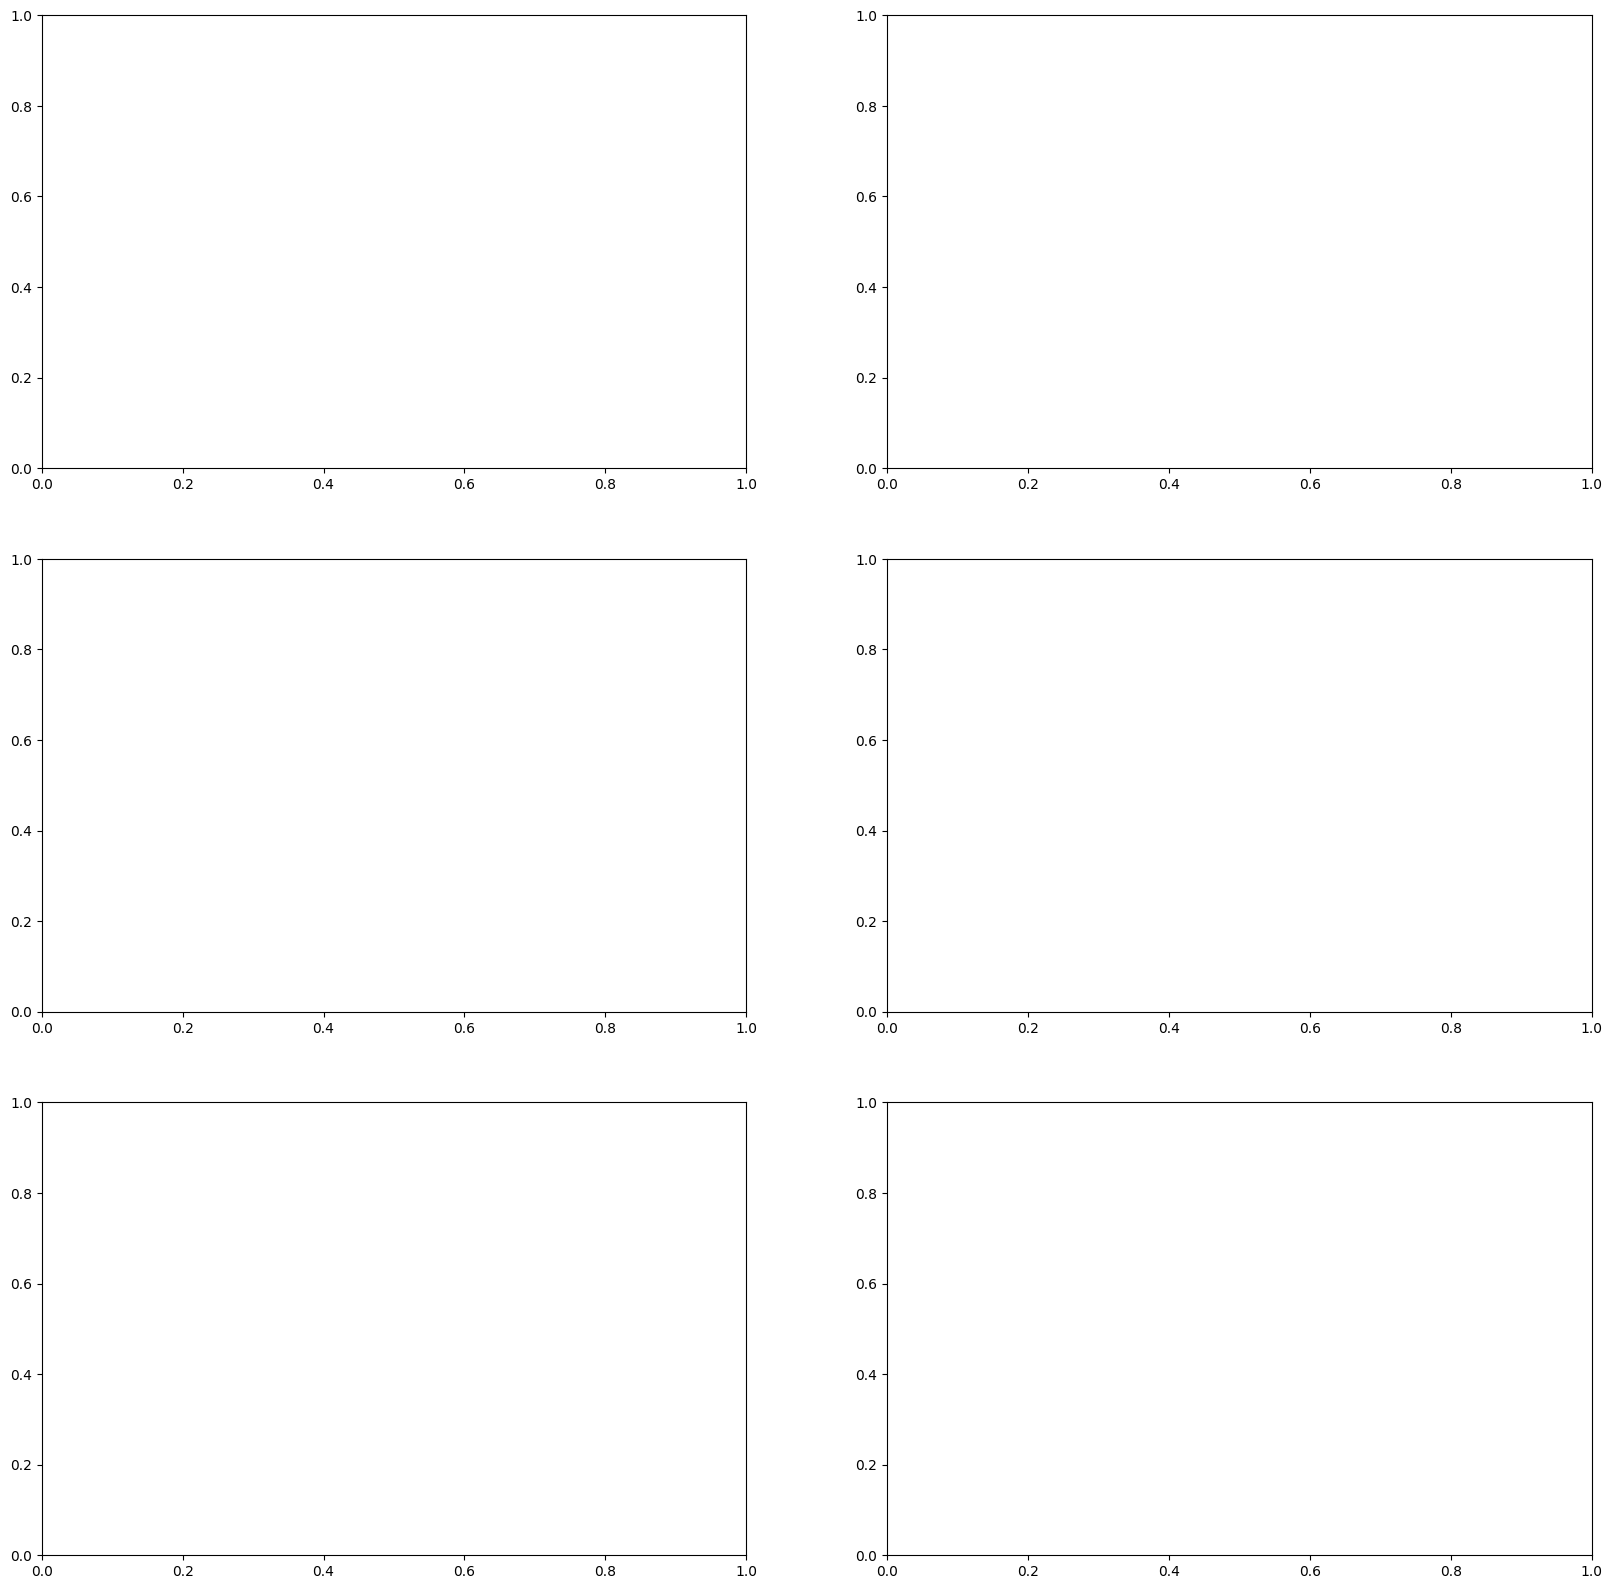

In [42]:
### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

### ACTUAL CALCULATION

a_big_c5 = arr_big[:,0,...]
a_big_c6 = arr_big[:,1,...]

x_vals_big_c5 = {"LL":(67.7, 308), "L":(98.7, 280), "LM":(130, 310), "M": (178, 308)}
x_vals_big_c6 = {"LL":(67.7, 458), "L":(98.7, 430), "LM":(130, 460), "M": (178, 458)}

fig, ax = plt.subplots(3, 2, figsize=(20,20))    
ax = ax.flatten()

im = plt.imread("/home/andres/C_SMA_LAR_white3.png")

for musc,m in enumerate(model.response):

    a_big_c5_m = a_big_c5[...,musc]
    a_big_c6_m = a_big_c6[...,musc]

    a_mean_big_c5 = ma.mean(a_big_c5_m, axis=(1))
    a_mean_small_c6 = ma.mean(a_big_c6_m, axis=(1))
    
    
    pvalues = []
    mask = []
    data = []
    mean_list_big_c5 = []
    mean_list_big_c6 = []

    for sub_ind, s in enumerate(subjects):
        for l_ind, l in enumerate(labels):
            if a_mean_big_c5.mask[sub_ind,l_ind].all():
                    continue
                
            mean_list_big_c5.append(
                (
                    subjects[sub_ind],
                    labels[l_ind],
                    a_mean_big_c5[sub_ind,l_ind],
                    (p_big_c5_means[sub_ind, l_ind,0])
                )
            )
            
    for sub_ind, s in enumerate(subjects):
        for l_ind, l in enumerate(labels):
            if a_mean_big_c6.mask[sub_ind,l_ind].all():
                    continue
                
            mean_list_big_c6.append(
                (
                    subjects[sub_ind],
                    labels[l_ind],
                    a_mean_big_c6[sub_ind,l_ind],
                    p_big_c6_means[sub_ind, l_ind,0]
                )
            )

    max_c5 = max([x[3] for x in mean_list_big_c5])
    max_c6 = max([x[3] for x in mean_list_big_c6])

    mean_alphas_c5 = [x[3]/max_c5 for x in mean_list_big_c5]
    mean_alphas_c6 = [x[3]/ max_c6 for x in mean_list_big_c6]

    mean_alphas_c5 = [x**2 for x in mean_alphas_c5]
    mean_alphas_c6 =  [x**2 for x in mean_alphas_c6]
    # plt.figure(figsize=(20, 20))
        
    for i, z in enumerate(mean_list_big_c5):
        if z[1] not in x_vals_big_c5:
            continue
        eff_size = (1/mean_list_big_c5[i][2])*300
        ax[musc].scatter(x_vals_big_c5[z[1]][0], x_vals_big_c5[z[1]][1], s = eff_size,alpha=mean_alphas_c5[i], color = model._get_colors(model.n_response)[musc])
        
    for i, z in enumerate(mean_list_big_c6):
        if z[1] not in x_vals_big_c6:
            continue
        eff_size = (1/mean_list_big_c6[i][2])*300
        ax[musc].scatter(x_vals_big_c6[z[1]][0], x_vals_big_c6[z[1]][1], s = eff_size,alpha=mean_alphas_c6[i], color = model._get_colors(model.n_response)[musc])
    plt.tight_layout()
    implot = ax[musc].imshow(im)
    ax[musc].set_xticklabels([])
    ax[musc].set_yticklabels([])
    ax[musc].set_title(f"{model.response[musc]}")

#   

In [131]:
arr_small = ma.masked_invalid(arr_small)

In [132]:
arr_small.shape

(8, 2, 4000, 5, 6)

In [133]:
arr_big.shape

(8, 2, 4000, 5, 6)

In [134]:
arr_mean_big = ma.mean(arr_big[:,:,:,[0,1,2,4],:], axis=(2))
arr_mean_small = ma.mean(arr_small, axis=(2))

In [135]:
arr_mean_big.shape

(8, 2, 4, 6)

In [136]:
small_diffs = arr_mean_small[:,:, None, :,:] - arr_mean_small[:,:,:,None,:]
big_diffs = arr_mean_big[:,:, None, :,:] - arr_mean_big[:,:,:,None,:]

In [137]:
small_diffs.shape

(8, 2, 5, 5, 6)

In [138]:
big_diff_means = ma.mean(big_diffs, axis = 1)
small_diff_means = ma.mean(small_diffs, axis = 1)


In [157]:
comp_arr_mean_big.shape

(8, 2, 5, 6)

In [154]:
comp_arr_mean_big = ma.mean(arr_big, axis=(2))
size_diffs = comp_arr_mean_big - arr_mean_small

In [156]:
size_diffs

(8, 2, 5, 6)

# 

# 12.16 HeatMaps

In [139]:
def musc_heat(musc,diff_data, size):
    if size == 1:
        labels = ['LL', 'L', 'LM1', 'LM2', 'M']
    else:
        labels = ['LL', 'L', 'LM', 'M']

    pvalues = []
    for i in range(len(diff_data[0,:,0,musc])):
        for i2 in range(len(diff_data[0,:,0,musc])):
            if i==i2:
                pvalues.append(1)
                continue
            temp_p = stats.wilcoxon(diff_data[:,i, i2,musc], axis=0).pvalue
            pvalues.append(temp_p)

    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(len(diff_data[0,:,0,musc]),len(diff_data[0,:,0,musc]))
    annotation = diff_data[:,:,:,musc]
    annotation = ma.mean(annotation, axis = 0).data

    mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(annotation, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False).set_title(f"{model.response[musc]}")
    

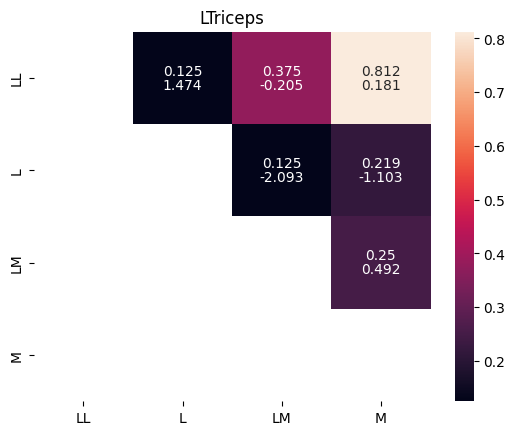

In [148]:
musc_heat(5, big_diff_means,0)

In [159]:
size_diffs = ma.mean(size_diffs, axis = 1)

In [177]:
annotation

NameError: name 'annotation' is not defined

In [193]:
def size_comp_heat(musc,diff_data):
    labels = ['LL', 'L', 'LM-LM1', 'LM-LM2', 'M']

    pvalues = []
    annotation = []
    for i in range(len(diff_data[0,:,musc])):
        for i2 in range(len(diff_data[0,:,musc])):
            if i == i2:
                temp_p = stats.wilcoxon(diff_data[:,i,musc], axis=0).pvalue
                pvalues.append(temp_p)
                annotation.append(ma.mean(diff_data[:,i,musc], axis = 0))
            else:
                pvalues.append(1)
                annotation.append(0)

    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(len(diff_data[0,:,musc]),len(diff_data[0,:,musc]))
    annotation = np.array(annotation)
    annotation = annotation.reshape(len(diff_data[0,:,musc]),len(diff_data[0,:,musc]))

    mask = np.tril(np.ones_like(pvalues), k=-1).astype(bool) + np.triu(np.ones_like(pvalues), k=+1).astype(bool)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(annotation, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False).set_title(f"{model.response[musc]}")

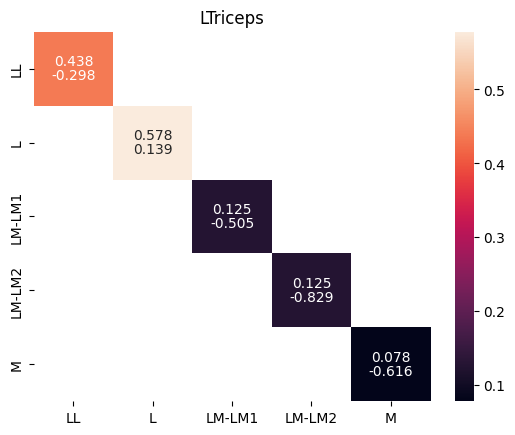

In [199]:
size_comp_heat(5,size_diffs)

<Axes: >

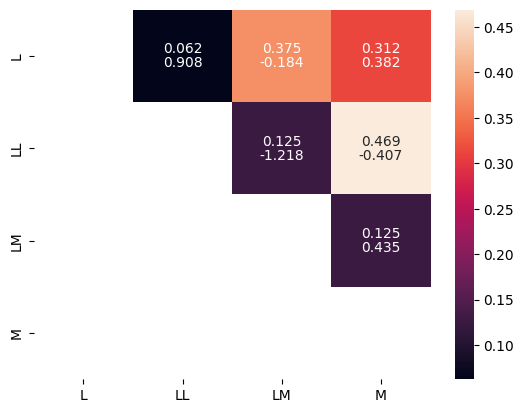

In [89]:
pvalues = []

big_diff_means_temp = ma.mean(big_diff_means, axis = -1)
for i in range(len(big_diff_means_temp[0,:,0])):
    for i2 in range(len(big_diff_means_temp[0,:,0])):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(big_diff_means_temp[:,i, i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(big_diff_means_temp[0,:,0]),len(big_diff_means_temp[0,:,0]))


mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(big_diff_means_temp.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

# block

In [115]:
ma.mean(diff_means)

-0.4589840806902633

In [104]:
stats.wilcoxon(diff_means, axis = 0)

WilcoxonResult(statistic=array([0., 2., 0., 0., 3.]), pvalue=array([0.25   , 0.1875 , 0.5    , 0.5    , 0.15625]))

In [155]:
arr_mean_big_lat = big_ind_musc[:,(0,1,2,4)]

In [43]:
t = arr_mean_big_lat[:,:,None] - arr_mean_big_lat[:,None,:]
t.shape

(8, 4, 4)

In [ ]:
arr_mean_big_lat.shape

(8, 4)

In [163]:
1/arr_mean_big_lat.mean(axis=0)

masked_array(data=[1.5571409287217037, 0.6487179991267892,
                   1.447054203672708, 0.8307993611656458],
             mask=[False, False, False, False],
       fill_value=1e+20)

In [ ]:
stats.sem(arr_mean_big_lat,axis=0)

array([0.08279817, 0.47628799, 0.11802534, 0.23283615])

In [46]:
pval = []
for i in range(t.shape[1]):
    for j in range(t.shape[2]):
        if i==j:
            pval.append(1)
        else:
            pval.append(stats.wilcoxon(t[:,i,j])[1])

In [48]:
diff = arr_mean_big - arr_mean_small

In [49]:
diff.shape

(8, 1, 5, 6)

In [50]:
t = diff[:, :, [0, 2, 3,], :].mean(axis=( 2, 3))
t.mean(axis=0)

masked_array(data=[-0.7428334203207084],
             mask=[False],
       fill_value=1e+20)

In [51]:
stats.wilcoxon(t, axis=0)

WilcoxonResult(statistic=array([0.]), pvalue=array([0.0625]))

In [52]:
stats.sem(t, axis=0)

array([0.28697551])

In [53]:
diff.shape

(8, 1, 5, 6)

In [54]:
diff = ma.mean(diff, axis=(2,-1))

In [55]:
diff.shape

(8, 1)

In [56]:
diff.mean()

-0.33745838221975427

In [57]:
stats.sem(diff, axis=0)

array([0.26247289])

In [58]:
stats.ttest_1samp(t, axis=0, popmean=0)

TtestResult(statistic=array([-2.5884906]), pvalue=array([0.06078055]), df=array([4.]))

In [59]:
t.mask

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False]])

In [60]:
stats.wilcoxon(t, axis=0).pvalue

array([0.0625])

In [61]:
labels = ['L', 'LL', 'LM1','LM2', 'M']
pvalues = []
for i in range(len(labels)):
    temp_p = stats.wilcoxon(diff, axis=0).pvalue
    pvalues.append(temp_p)

In [62]:
pvalues

[array([0.296875]),
 array([0.296875]),
 array([0.296875]),
 array([0.296875]),
 array([0.296875])]

In [193]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/C_SMA_LAR/cst_selectivity_means.pkl"
with open(src, "rb") as f:
    selectivity_small, selectivity_big = pickle.load(f)

In [188]:
selectivity_small

masked_array(
  data=[[[0.6739609881646469, 0.9522769464308535, 0.6479455145851215,
          0.5715017805069169, 0.45693566920187084]],

        [[0.9835957532553877, 0.9138785863420731, 1.1965049346870265,
          0.9317709058951679, 1.1610791553503]],

        [[0.698850038990781, 0.931095944421215, 0.6560475793777696,
          0.6292440972696213, 0.6078576090069514]],

        [[1.1820277764933398, 1.2665546574294646, 1.4271071605632932,
          1.2465028843196695, 0.8298234887150198]],

        [[0.778457517828389, 0.754068415352096, 0.8967727317592703,
          0.8422666722386505, 0.7792464260518837]],

        [[0.646334901330812, 0.6536875570088372, 0.7216792769779491,
          0.7250399297537776, 0.5056770213783495]],

        [[0.5813551207862371, 0.8858163658708895, 0.47008787634923055,
          0.7054405101020675, 0.5372532514116292]],

        [[1.405196802818975, 1.2243922508036136, 1.363345656331414,
          1.394913824162516, 0.9130352435761103]]],
  mask=[[[F

In [189]:
arr_mean_big.shape

(8, 1, 5, 6)

In [66]:
combined = np.concatenate([arr_mean_small[...,None], arr_mean_big[ ...,None]], axis=4) 

In [67]:
arr_mean_small[0,0,0,0]

0.614797253069905

In [68]:
combined.shape

(8, 1, 5, 6, 2)

In [69]:
small = combined[...,0]

In [70]:
big = combined[...,1]

In [71]:
small_mean = ma.mean(small, axis=(1,-1))

In [72]:
big_mean = ma.mean(big, axis=(1,-1))

In [73]:
big_mean.shape

(8, 5)

In [74]:
arr_mean_big_lat.shape

(8, 4)

In [75]:
inds = [0,1,2,4]

In [76]:
big_mean = big_mean[:,inds]

In [77]:
big_mean.shape

(8, 4)

In [78]:
big_diff = arr_mean_big_lat[:,:,None] - arr_mean_big_lat[:,None,:]

In [79]:
small_diff = small_mean[:,:,None] - small_mean[:,None,:]

In [80]:
small_diff.shape

(8, 5, 5)

In [81]:
avg_small = ma.mean(combined[...,0], axis=(0,1,-1))
avg_big = ma.mean(combined[...,1], axis=(0,1,-1))

avg_sel_small = ma.mean(selectivity_small[:,0,:], axis=(0))
avg_sel_big = ma.mean(selectivity_big[:,0,:], axis=(0))

In [194]:
selectivity_small = selectivity_small.mean(axis=1)
selectivity_big = selectivity_big.mean(axis=1)

In [195]:
avg_sel_small = ma.mean(selectivity_small, axis=(0))
avg_sel_big = ma.mean(selectivity_big, axis=(0))

In [182]:
selectivity_small.shape

(8, 2, 5)

In [185]:
selectivity_small[:,0,:].mean(axis=0)

masked_array(data=[0.8687223624585712, 0.9477213404573802,
                   0.9224363413288843, 0.8808350755310485,
                   0.7238634830865143],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [84]:
sem_eff_big = []
sem_sel_big = []
for i in range(len(combined[0,0,:,0,0])):
    sem_eff_big.append(ma.std(combined[:,:,i,:,1]) / ma.sqrt(ma.count(combined[:,:,i,:,1])))
    sem_sel_big.append(ma.std(selectivity_big[:,0,i]) / ma.sqrt(ma.count(selectivity_big[:,0,i])))
    
sem_eff_small = []
sem_sel_small = []
for i in range(len(combined[0,0,:,0,0])):
    sem_eff_small.append(ma.std(combined[:,:,i,:,0]) / ma.sqrt(ma.count(combined[:,:,i,:,0])))
    sem_sel_small.append(stats.sem(selectivity_small[:,0,i]))

In [85]:
plot_big_inds = (0,1,2,4)

In [86]:
avg_big = np.delete(avg_big, 3)

In [197]:
sem_sel_big = stats.sem(selectivity_big,axis=0)
sem_sel_small = stats.sem(selectivity_small,axis=0)

In [201]:
sem_sel_big

array([0.08877148, 0.1573769 , 0.07722596, 0.08427844])

In [200]:
avg_sel_big= np.delete(avg_sel_big, 3)
sem_sel_big = np.delete(sem_sel_big, 3)
# sem_eff_big = np.delete(sem_eff_big, 3)

In [119]:
avg_big

masked_array(data=[0.40137664, 1.34881412, 0.34552956, 1.05320254],
             mask=False,
       fill_value=1e+20)

In [ ]:
avg_sel_big = 

In [89]:
labels = ['L', 'LL', 'LM1','LM2', 'M']

In [90]:
1/avg_small

masked_array(data=[0.8013070856549561, 0.6732279995332888,
                   0.8116963355588142, 0.8282295382156813,
                   0.6512620939202196],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [91]:
arr_mean_big_lat.shape

(8, 4)

In [92]:
avg_small = ma.mean(arr_mean_small_lat, axis=0)


In [120]:
arr_mean_big_lat.shape

(8, 4)

In [121]:
avg_big = ma.mean(arr_mean_big_lat, axis=0)

In [123]:
sem_eff_big = stats.sem(1/arr_mean_big_lat, axis=0)

In [93]:
1/avg_small

masked_array(data=[0.8013070856549563, 0.6732279995332888,
                   0.8116963355588142, 0.8282295382156813,
                   0.6512620939202197],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [117]:
sem_eff_small = stats.sem(1/arr_mean_small_lat, axis=0)

In [181]:
1/arr_mean_small_lat.mean(axis=0)

masked_array(data=[0.8013070856549563, 0.6732279995332888,
                   0.8116963355588142, 0.8282295382156813,
                   0.6512620939202197],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [178]:
sem_eff_small

array([0.08690983, 0.09837154, 0.0904454 , 0.08721152, 0.06610738])

In [95]:
sem_eff_small

array([0.20521223, 0.25686986, 0.2113423 , 0.15182129, 0.17504015])

In [96]:
sem_sel_small = stats.sem(selectivity_small[:,0,:], axis=0)

In [97]:
sem_sel_big = stats.sem(selectivity_big[:,0,(0,1,3,4)], axis=0)

In [98]:
sem_sel_big.shape

(4,)

In [186]:
selectivity_big[:,0,(0,1,3,4)].mean(axis=0)

masked_array(data=[0.665809723212093, 0.8499952255063293,
                   0.6150062529379308, 0.6887442006707778],
             mask=[False, False, False, False],
       fill_value=1e+20)

In [109]:
avg_big.data

array([0.40137664, 1.34881412, 0.34552956, 1.05320254])

In [108]:
avg_small.data

array([1.24796101, 1.48538088, 1.23198782, 1.20739475, 1.53548012])

In [124]:
combine_eff= np.concatenate((avg_small.data, avg_big.data), axis=None)
combine_eff_sems = np.concatenate((sem_eff_small, sem_eff_big), axis=None)

In [202]:
combine_sel = np.concatenate((avg_sel_small, avg_sel_big), axis=None)
combine_sel_sems = np.concatenate((sem_sel_small, sem_sel_big), axis=None)

In [205]:
avg_sel_big

masked_array(data=[0.66580972, 0.84999523, 0.61500625, 0.6887442 ],
             mask=False,
       fill_value=1e+20)

In [ ]:
combine_eff[[0,2,3,5,7]]

array([1.24796101, 1.23198782, 1.20739475, 0.64220263, 0.69105912])

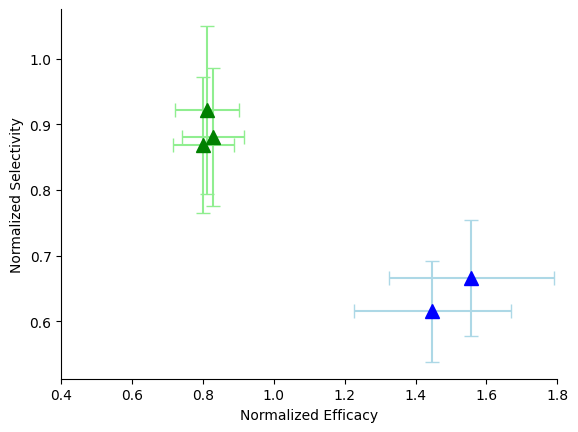

In [228]:
for i in range(len(combine_eff)):
    if i in [0,2,3,5,7]:
        if i<5:
            plt.errorbar(x=1/combine_eff[i], y=combine_sel[i], yerr=combine_sel_sems[i], xerr=combine_eff_sems[i], fmt='^', capsize=5,ms = 10, ecolor='lightgreen',    markerfacecolor='green',  # Fill color of the marker
        markeredgecolor='green', label='Avg with SEM')
        else:
            plt.errorbar(x=1/combine_eff[i], y=combine_sel[i], yerr=combine_sel_sems[i], xerr=combine_eff_sems[i], fmt='^', capsize=5,ms = 10, ecolor='lightblue',    markerfacecolor='blue',  # Fill color of the marker
        markeredgecolor='blue', label='Avg with SEM')
    else:
        continue
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
plt.xlim([0.4, 1.8])
sns.despine()

In [227]:
diff.shape

(8, 1, 5, 6)

In [228]:
diff_sel = selectivity_big[:,0,:] - selectivity_small[:,0,:]

In [259]:
diff_sel[:,(0,2,3)].shape

(8, 3)

In [261]:
diff_sel[:,(0,2,3)].mean(axis = 1)

masked_array(data=[-0.15557439819350102, -0.46546639940704476,
                   -0.2704087558144766, --, --, --, 0.1569912398675787,
                   -0.5709378793527331],
             mask=[False, False, False,  True,  True,  True, False, False],
       fill_value=1e+20)

In [262]:
stats.wilcoxon(diff_sel[:,(0,2,3)].mean(axis = 1), axis=0)

WilcoxonResult(statistic=2.0, pvalue=0.1875)

In [230]:
diff_eff = ma.mean(diff, axis=(1,-1))

In [234]:
diff_eff.shape

(8, 5)

In [250]:
avg_diff_sel = ma.mean(diff_sel, axis=0)
avg_diff_eff = ma.mean(diff_eff, axis=0)
sem_diff_sel = stats.sem(diff_sel, axis=0)
sem_diff_eff = stats.sem(diff_eff, axis=0)

In [251]:
avg_diff_eff

masked_array(data=[-0.7809718606794567, 0.029644101549534944,
                   -0.7648537083177461, -0.6488356067229413,
                   -0.355794767869014],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [253]:
avg_diff_sel

masked_array(data=[-0.20278201759111258, -0.13973094115798565,
                   -0.3044647425502673, -0.2859005022287363,
                   -0.06628877694547428],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

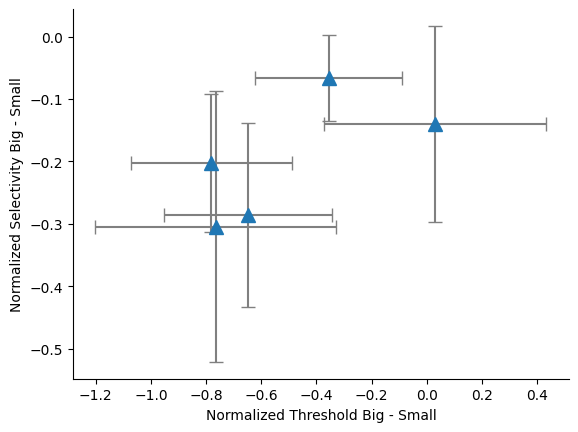

In [252]:
plt.errorbar(x=avg_diff_eff, y=avg_diff_sel, yerr=sem_diff_sel, xerr=sem_diff_eff, fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Threshold Big - Small")
plt.ylabel("Normalized Selectivity Big - Small")
sns.despine()

# Old

In [ ]:
means_a = ma.mean(arr_diffs, axis=(1,-1))

In [ ]:
means_a.shape

(8, 5, 5)

In [ ]:
compound_position

array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR', 'C5L-C5LL',
       'C5LM1-C5L', 'C5LM1-C5LL', 'C5LM2-C5L', 'C5LM2-C5LL',
       'C5LM2-C5LM1', 'C5LM2-C5M', 'C5LM2-C6L', 'C5LM2-C6LL', 'C5M-C5L',
       'C5M-C5LL', 'C5M-C5LM', 'C5M-C5LM1', 'C5M-C5LM2', 'C5M-C6L',
       'C5M-C6LL', 'C6L-C6LL', 'C6LL-C6L', 'C6LM-C6L', 'C6LM-C6LL',
       'C6LM-C6M', 'C6LM-C6R', 'C6LM-C6RM', 'C6LM-C6RR', 'C6LM1-C6L',
       'C6LM1-C6LL', 'C6LM2-C6L', 'C6LM2-C6LL', 'C6LM2-C6LM1', 'C6M-C6L',
       'C6M-C6LL', 'C6M-C6LM', 'C6M-C6LM1', 'C6M-C6LM2', 'C6M-C6R',
       'C6M-C6RM', 'C6M-C6RR', 'C6R-C6RR', 'C6RM-C6R', 'C6RM-C6RR',
       'C7LM-C7M', 'C7LM-C7R', 'C7LM-C7RM', 'C7LM-C7RR', 'C7M-C7R',
       'C7M-C7RM', 'C7M-C7RR', 'C7R-C7RR', 'C7RM-C7R', 'C7RM-C7RR'],
      dtype=object)

In [ ]:
labels = ['L', 'LL', 'LM', 'M']
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(means_a[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))

<Axes: >

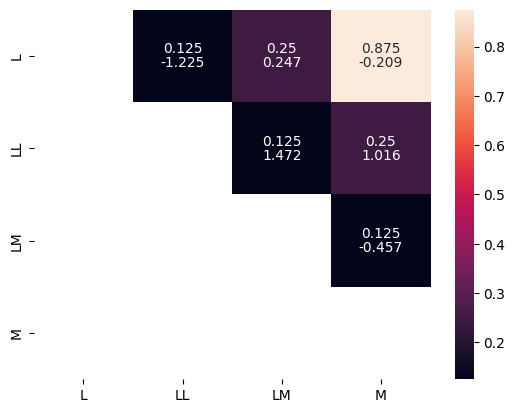

In [ ]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(means_a.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

# MEP amp

In [ ]:
c5_big = a[:,:,p1,0,:]
c6_big = a[:,:,p2,0,:]

In [141]:
big.shape

(8, 2, 6, 6)

In [140]:
big = ma.mean(big, axis=(3,5))

In [143]:
small.shape

(8, 2, 6, 6)

In [142]:
small = ma.mean(small, axis=(3,5))

In [142]:
big.shape

(8, 2, 6, 400, 6, 1)

In [144]:
big = big[:,:,:,big_ind]
small = small[:,:,:,small_ind]

In [145]:
diffs = big - small

In [146]:
diffs.shape

(8, 2, 6, 5)

In [147]:
diffs_mean = ma.mean(diffs, axis=(1,2,3))

In [148]:
stats.wilcoxon(diffs_mean, axis=0)

WilcoxonResult(statistic=4.0, pvalue=0.109375)

In [ ]:
means_c5 = ma.mean(norm_y[:,0,...], axis=(2,4))
means_c6 = ma.mean(norm_y[:,1,...], axis=(2,4))

means_c5_diff = means_c5[:,:,None] - means_c5[:,None,:]
means_c6_diff = means_c6[:,:,None] - means_c6[:,None,:]

In [ ]:
means_c5_diff = means_c5[:,:,:,None] - means_c5[:,:,None,:]
means_c6_diff = means_c6[:,:,:,None] - means_c6[:,:,None,:]

In [ ]:
means_c5_diff.shape

(8, 6, 6, 6)

In [ ]:
means_c6.shape

(8, 6, 6)

In [ ]:
t = ma.mean(ma.array([means_c5_diff, means_c6_diff]), axis=(0))

In [ ]:
t.shape

(8, 6, 6, 6)

In [ ]:
stats.wilcoxon(t[:,4, 0, 5], axis=0)

WilcoxonResult(statistic=array([6.]), pvalue=array([0.109375]))

In [ ]:
t = ma.mean(t, axis=1)

In [ ]:
t.shape

(8, 6, 6)

<Axes: >

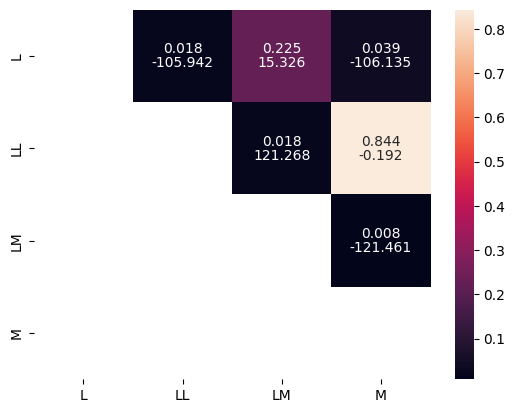

In [155]:
pvalues = []
for i in range(4):
    for i2 in range(4):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(big_diff[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(4, 4)

labels = ['L', 'LL', 'LM', 'M']
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(big_diff.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [ ]:
t.shape

(8, 6, 6)